## Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm
from easydict import EasyDict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation

import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, random_split
import cv2

from dataset import BasketballDataset
from utils.checkpoints import load_weights
from utils.metrics import get_acc_f1_precision_recall

from IPython.display import HTML, Image

## Args

In [2]:
args = EasyDict({

    'base_model_name': 'r2plus1d_multiclass',
    'pretrained': True,

    # training/model params
    'lr': 0.0001,
    'start_epoch': 19,
    # 19, 15, 3

    # Dataset params
    'num_classes': 10,
    'batch_size': 8,
    'n_total': 49901,
    'test_n': 4990,
    'val_n': 9980,

    # Path params
    'annotation_path': "dataset/annotation_dict.json",
    'augmented_annotation_path': "dataset/augmented_annotation_dict.json",
    'model_path': "model_checkpoints/r2plus1d_augmented-2/",
    'history_path': "histories/history_r2plus1d_augmented-2.txt"
})

## Functions

In [19]:
def batch_to_framelist(batch):
    # (batch, c, t, h, w) -> (batch, t, h, w, c)
    batch = batch.permute(0, 2, 3 ,4 ,1)
    framelist = batch.cpu().numpy()
    return framelist

def inference(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    pred_classes = []
    ground_truths = []
    f1_score = []

    correct = []
    incorrect = []

    correct_softmax, incorrect_softmax = [], []

    with torch.no_grad():
        i = args.batch_size

        pbar = tqdm(loader)
        for sample in pbar:
            raw_data = batch_to_framelist(sample["video"])
            x = sample["video"].to(device=device)
            y = sample["action"].to(device=device)

            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            y_ = y.argmax (1)

            num_correct += (preds == y_).sum()
            num_samples += preds.size(0)

            # predicted class
            pred_class = preds.detach().cpu().numpy()
            pred_classes.extend(pred_class)
            # ground truth
            gt = torch.max(y, 1)[1].detach().cpu().numpy()
            ground_truths.extend(gt)

            # Convert back into cpu
            softmax_predictions = torch.softmax(outputs, dim=-1).cpu().numpy().tolist()
            softmax_preds = [max(pred) for pred in softmax_predictions]

            for framedata, softpred, softpreds, predlabel, label in zip(raw_data, softmax_preds, softmax_predictions, pred_class, gt):
                # If correct
                if predlabel == label:
                    correct.append({
                        'frames': framedata,
                        'softpred': softpred,
                        'softpreds': softpreds,
                        'prediction': predlabel,
                        'label': label,
                    })
                    correct_softmax.append(softpred)

                # If incorrect
                else:
                    incorrect.append({
                        'frames': framedata,
                        'softpred': softpred,
                        'softpreds': softpreds,
                        'prediction': predlabel,
                        'label': label,
                    })
                    correct_softmax.append(softpred)

            pbar.set_description('Progress: {}'.format(i/args.test_n))
            i += args.batch_size

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    model.train()

    pred_classes = np.asarray(pred_classes)
    ground_truths = np.asarray(ground_truths)
    val_accuracy, val_f1, val_precision, val_recall = get_acc_f1_precision_recall(
        pred_classes, ground_truths
    )
    f1_score.append(val_f1)

    confusion_matrix_ = np.array_str(
        confusion_matrix(ground_truths, pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
    print(f'val: \n{confusion_matrix_}')

    predictions = {
        "correct": correct,
        "incorrect": incorrect,
    }
    return predictions, confusion_matrix_

def visualize(err_list, path, num=10):
    """
    Given lists of true positive, false positive, true negative, and false negatives, visualize the clips
    :param err_list: list created from validation, with errors included
    :param num: number of videos to visualize 
    :return: None
    """
    
    # create animation
    fig = plt.figure()

    vidframes = []
    softpreds = []
    predlabels = []
    labels = []
    correct_preds = []
    
    for item in err_list[:num]:
        frames = item['frames']
        softpred = item['softpred']
        predlabel = item['prediction']
        label = item['label']
        correct_pred = item['softpreds'][label]
        
        # resize 
        for i in range(frames.shape[0]):
            vidframes.append(frames[i])
            softpreds.append(softpred)
            predlabels.append(predlabel)
            labels.append(label)
            correct_preds.append(correct_pred)
        
        # add 15 empty frames as buffer
        vidframes = vidframes + [
            np.zeros((int(frames[i].shape[1]), int(frames[i].shape[0]), 3), dtype=np.uint8) for i in range(15)
        ]
        softpreds = softpreds + [0 for i in range(15)]
        predlabels = predlabels + [0 for i in range(15)]
        labels = labels + [0 for i in range(15)]
        correct_preds = correct_preds + [0 for i in range(15)]
    
    labels_dict = {"0" : "block", "1" : "pass", "2" : "run", "3" : "dribble", "4" : "shoot", "5" : "ball in hand", "6" : "defense", "7" : "pick" , "8" : "no_action" , "9" : "walk" , "10" : "discard"}
    
#     writer = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*"MP4V"), 30, (176, 128))
#     for frame in vidframes:
#         print(frame.shape)
#         writer.write(frame)
#     writer.release()
        
    im = plt.figimage(vidframes[0], resize=True)
    # animation function
    def animate(i):
        # Normalize Across Channels
        for x in range(3):
#             print(np.amax(vidframes[i][:,:, x]))
#             print(np.amin(vidframes[i][:,:, x]))
            vidframes[i][:, :, x] = vidframes[i][:,:, x] / 255.0
        im.set_array(vidframes[i])
        fig.suptitle(f'Softmax Pred: {softpreds[i]} Predicted Label: {predlabels[i]} \n Softmax Pred for {labels[i]}: {correct_preds[i]}', fontsize=7, color='red')
        return (im,)
    
    print(animation.writers)
    Writer = animation.writers['pillow']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    
    # animate
    anim = animation.FuncAnimation(fig, animate, frames=len(vidframes), interval=15, repeat_delay=1, repeat=True)
    if os.path.exists(path):
        os.remove(path)
        anim.save(path, writer=writer)
    else:
        anim.save(path, writer=writer)

## Evaluate

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize R(2+1)D Model
model = models.video.r2plus1d_18(pretrained=args.pretrained, progress=True)

# input of the next hidden layer
num_ftrs = model.fc.in_features
# New Model is trained with 128x176 images
# Calculation:
model.fc = nn.Linear(num_ftrs, args.num_classes, bias=True)
print(model)

model = load_weights(model, args)

if torch.cuda.is_available():
    # Put model into device after updating parameters
    model = model.to(device)

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [5]:
#Load Dataset
basketball_dataset = BasketballDataset(annotation_dict=args.annotation_path,
                                       augmented_dict=args.augmented_annotation_path)

train_subset, test_subset = random_split(
basketball_dataset, [args.n_total-args.test_n, args.test_n], generator=torch.Generator().manual_seed(1))

train_subset, val_subset = random_split(
    train_subset, [args.n_total-args.test_n-args.val_n, args.val_n], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=args.batch_size)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_subset, shuffle=False, batch_size=args.batch_size)

In [6]:
predictions, confusion_matrix_ = inference(test_loader, model)

Progress: 1.0004008016032064: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [04:04<00:00,  2.55it/s]

Got 4244 / 4990 with accuracy 85.05
[8 9 6 ... 9 9 8]
[9 8 8 ... 8 9 9]
val: 
[[498   1   0   1   5   0   1   0   0   4]
 [  4 522   1  13   3   7   0   1   0   6]
 [  2   0 480   6   0   4   9   1   0  93]
 [  0   0   1 307   0   7   3   1   0   6]
 [  5   0   0   0 202   0   0   1   0   2]
 [  3   8   5  10   3 160   1   1   5  12]
 [ 16   0   6   4   0   3 290   3  24  64]
 [  9   5   1   0   1   0   0 325   6  10]
 [  8   5   1   1   1   4  22   3 474 135]
 [ 16   1  42   3   0   5  39   6  66 986]]


In [7]:
correct = predictions["correct"]
incorrect = predictions["incorrect"]

In [8]:
print(len(correct))

4244


In [9]:
print(len(incorrect))

746


In [10]:
labels_dict = {"0" : "block", "1" : "pass", "2" : "run", "3" : "dribble", "4" : "shoot", "5" : "ball in hand", "6" : "defense", "7" : "pick" , "8" : "no_action" , "9" : "walk" , "10" : "discard"}

In [11]:
true_block = [ x for x in correct if x["prediction"] == 0]
true_pass = [ x for x in correct if x["prediction"] == 1]
true_run = [ x for x in correct if x["prediction"] == 2]
true_dribble = [ x for x in correct if x["prediction"] == 3]
true_shoot = [ x for x in correct if x["prediction"] == 4]
true_ball_in_hand = [ x for x in correct if x["prediction"] == 5]
true_defence = [ x for x in correct if x["prediction"] == 6]
true_pick = [ x for x in correct if x["prediction"] == 7]
true_no_action = [ x for x in correct if x["prediction"] == 8]
true_walk = [ x for x in correct if x["prediction"] == 9]

In [12]:
false_block = [ x for x in incorrect if x["prediction"] == 0]
false_pass = [ x for x in incorrect if x["prediction"] == 1]
false_run = [ x for x in incorrect if x["prediction"] == 2]
false_dribble = [ x for x in incorrect if x["prediction"] == 3]
false_shoot = [ x for x in incorrect if x["prediction"] == 4]
false_ball_in_hand = [ x for x in incorrect if x["prediction"] == 5]
false_defence = [ x for x in incorrect if x["prediction"] == 6]
false_pick = [ x for x in incorrect if x["prediction"] == 7]
false_no_action = [ x for x in incorrect if x["prediction"] == 8]
false_walk = [ x for x in incorrect if x["prediction"] == 9]

In [13]:
print(true_block[0]["frames"].shape)

(16, 176, 128, 3)


In [20]:
visualize(true_block, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_block.gif')
visualize(true_pass, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_pass.gif')
visualize(true_run, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_run.gif')
visualize(true_dribble, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_dribble.gif')
visualize(true_shoot, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_shoot.gif')
visualize(true_ball_in_hand, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_ball_in_hand.gif')
visualize(true_defence, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_defence.gif')
visualize(true_pick, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_pick.gif')
visualize(true_no_action, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_no_action.gif')
visualize(true_walk, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/true_walk.gif')

<Figure size 128x176 with 0 Axes>

In [30]:
visualize(false_block, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_block.gif')
visualize(false_pass, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_pass.gif')
visualize(false_run, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_run.gif')
visualize(false_dribble, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_dribble.gif')
visualize(false_shoot, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_shoot.gif')
visualize(false_ball_in_hand, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_ball_in_hand.gif')
visualize(false_defence, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_defence.gif')
visualize(false_pick, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_pick.gif')
visualize(false_no_action, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_no_action.gif')
visualize(false_walk, 'visualize_predictions/r2plus1d_multiclass_19_0.0001/false_walk.gif')

<Figure size 128x176 with 0 Axes>

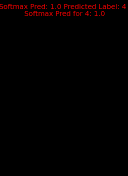

In [41]:
Image(open('visualize_predictions/r2plus1d_multiclass_19_0.0001/true_shoot.gif','rb').read())